Use the wine dataset (Task 2) to test the cost-complexity algorithm. In particular, you should:
load the data,
name the columns (using the description),
create a full tree (leaves with elements of one class),
draw the full tree,
check the effectiveness of the full tree by repeated substitution and crosvalidation,
choose the optimal tree (using the cost-complexity alg.), draw it and compare the results of its effectiveness with the full tree,
create a tree for the first: two, three, four, etc. variables - each time determine the optimal tree,
plot the effectiveness of the tree as a function of the number of variables used, as well as the differences in the size of the full tree and the optimal tree.

In [17]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

1. get dataset

In [18]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"

colNames=["group", "Alcohol", "Malic_acid", "Ash", "Alcalinity_of_ash ", "Magnesium", "Total_phenols", "Flavanoids", "Nonflavanoid_phenols", "Proanthocyanins", "Color_intensity", "Hue", "Code_of_diluted_wines", "Proline"]

data = pd.read_csv(
    url,
    sep=',',
    encoding='utf-8',
    names = colNames
)

dataNoClass=data.drop('group', axis=1)


2. create&draw full decision tree

In [19]:
clf = tree.DecisionTreeClassifier()
clf.fit(dataNoClass, data['group'])

DecisionTreeClassifier()

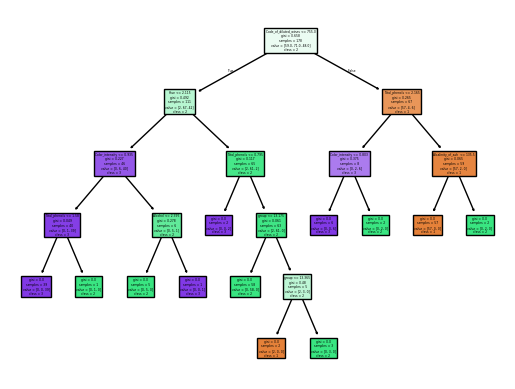

In [20]:
tree.plot_tree(clf, feature_names=colNames, class_names = ["1", "2","3"], filled = True)

plt.show()

3. crossvalidation

In [21]:
preds = clf.predict(dataNoClass)
print(metrics.classification_report(data.group, preds))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        59
           2       1.00      1.00      1.00        71
           3       1.00      1.00      1.00        48

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178



In [22]:
#using kfold with 5 folds
kf = RepeatedKFold(n_repeats = 5, n_splits = 5)

cross_val_score(clf, dataNoClass, data.group, cv = kf).mean()

np.float64(0.8955238095238096)

4. choosing optimal tree using cost-complexity pruning

In [23]:
path = clf.cost_complexity_pruning_path(dataNoClass, data.group)
path

{'ccp_alphas': array([0.        , 0.0093633 , 0.01087926, 0.01095506, 0.01685393,
        0.02111097, 0.02171015, 0.03830402, 0.06105021, 0.20542179,
        0.2517854 ]),
 'impurities': array([0.        , 0.0093633 , 0.03112181, 0.04207687, 0.0589308 ,
        0.08004177, 0.10175193, 0.14005595, 0.20110615, 0.40652794,
        0.65831334])}

In [24]:
param_grid = {'ccp_alpha': path['ccp_alphas']}

#using grid search
clf_grid = GridSearchCV(clf, param_grid)
clf_grid.fit(dataNoClass, data.group)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.        , 0.0093633 , 0.01087926, 0.01095506, 0.01685393,
       0.02111097, 0.02171015, 0.03830402, 0.06105021, 0.20542179,
       0.2517854 ])})

Text(0, 0.5, 'classification accuracy')

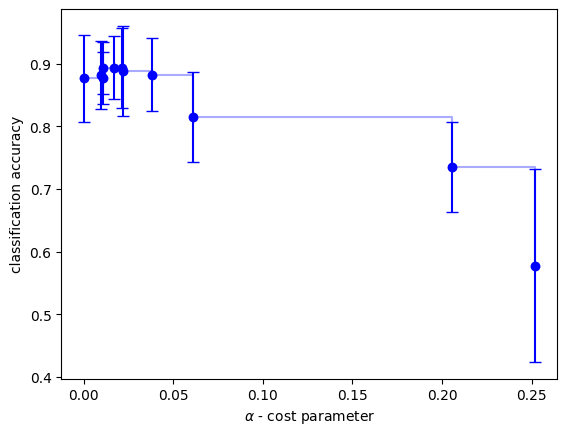

In [25]:
plt.plot(param_grid["ccp_alpha"], clf_grid.cv_results_["mean_test_score"], marker="o", drawstyle="steps-post", c = "#0000ff55")
plt.errorbar(param_grid["ccp_alpha"], clf_grid.cv_results_["mean_test_score"], clf_grid.cv_results_["std_test_score"], fmt="o", capsize=4, c = "#0000ff")
plt.xlabel(r"$\alpha$ - cost parameter")
plt.ylabel("classification accuracy")

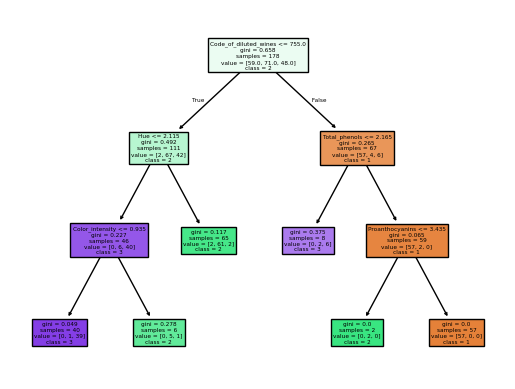

In [26]:
#plotting tree using estimated parameter
tree.plot_tree(clf_grid.best_estimator_, feature_names=colNames, class_names = ["1", "2","3"], filled = True);
plt.show()

In [27]:
# getting results based on smaller tree
preds = clf_grid.predict(dataNoClass)
print(metrics.classification_report(data.group, preds))
print(metrics.accuracy_score(data.group,preds))
cross_val_score(clf_grid, dataNoClass, data.group, cv = kf).mean()

#results slightly worse but still satisfying

              precision    recall  f1-score   support

           1       1.00      0.97      0.98        59
           2       0.93      0.96      0.94        71
           3       0.94      0.94      0.94        48

    accuracy                           0.96       178
   macro avg       0.96      0.95      0.95       178
weighted avg       0.96      0.96      0.96       178

0.9550561797752809


np.float64(0.8965079365079365)

In [38]:
acc=[]
cv=[]
acc_opt=[]
cv_opt=[]
size=[]
size_opt=[]

def all(X):

    clf = tree.DecisionTreeClassifier()
    clf.fit(X, data['group'])

    size.append(clf.tree_.n_leaves)
    preds = clf.predict(X)
    accuracy=metrics.accuracy_score(data.group, preds)
    acc.append(accuracy)
    kf = RepeatedKFold(n_repeats = 5, n_splits = 5)
    cvs=cross_val_score(clf, X, data.group, cv = kf).mean()
    cv.append(cvs)

    path = clf.cost_complexity_pruning_path(X, data.group)
    param_grid = {'ccp_alpha': path['ccp_alphas']}

    clf_grid = GridSearchCV(clf, param_grid)
    clf_grid.fit(X, data.group)

    size_opt.append(clf_grid.best_estimator_.tree_.n_leaves)
    preds = clf_grid.predict(X)
    accuracy2=metrics.accuracy_score(data.group, preds)
    acc_opt.append(accuracy2)
    cvs2=cross_val_score(clf_grid, X, data.group, cv = kf).mean()
    cv_opt.append(cvs2)
    

In [ ]:
#creating df with 2,3,...,12 cols
dfs=[]
for i in range(3, len(colNames) + 1):
    selected_columns = colNames[1:i] 
    new_df = dataNoClass[selected_columns].copy() 
    new_df_name = f'df{i-1}'  
    dfs.append(new_df)
    globals()[new_df_name] = new_df 

In [39]:
for i in dfs:
    all(i)

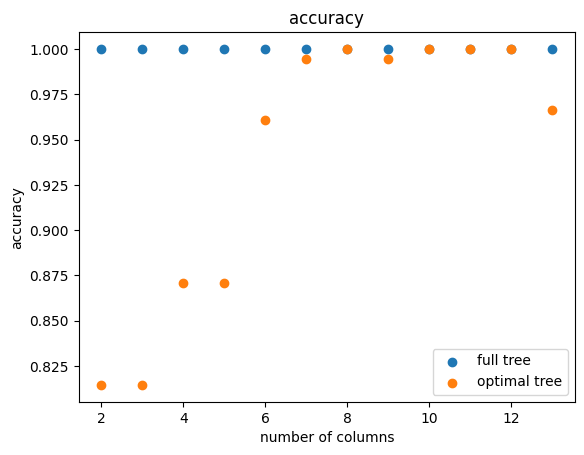

In [41]:
x=np.arange(2,14)
plt.scatter(x,acc, label='full tree')
plt.scatter(x,acc_opt, label='optimal tree')
plt.title('accuracy')
plt.xlabel('number of columns')
plt.ylabel('accuracy')
plt.legend()
plt.show()

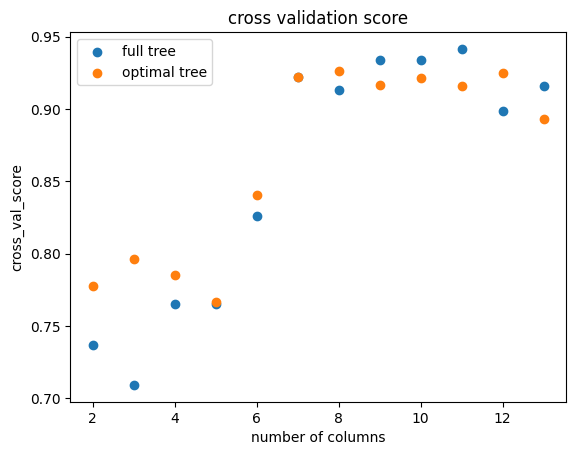

In [ ]:
x=np.arange(2,14)
plt.scatter(x,cv, label='full tree')
plt.scatter(x,cv_opt, label='optimal tree')
plt.title('cross validation score')
plt.xlabel('number of columns')
plt.ylabel('cross_val_score')
plt.legend()
plt.show()

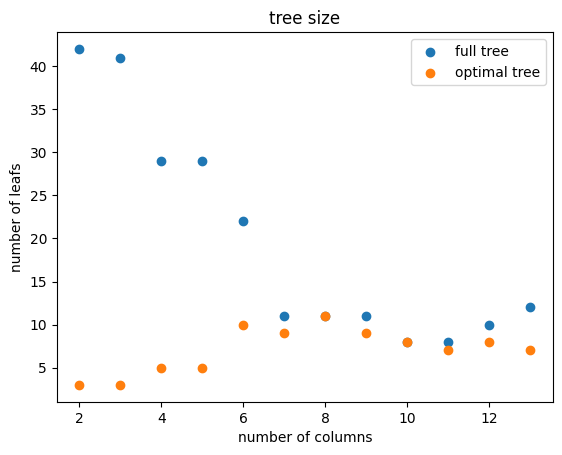

In [ ]:
x=np.arange(2,14)
plt.scatter(x,size, label='full tree')
plt.scatter(x,size_opt, label='optimal tree')
plt.title('tree size')
plt.xlabel('number of columns')
plt.ylabel('number of leafs')
plt.legend()
plt.show()

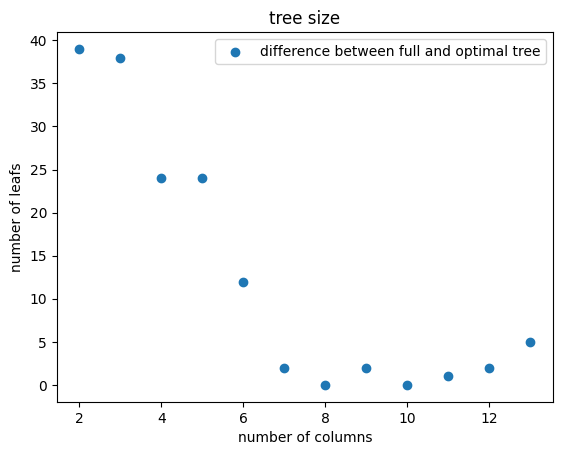

In [ ]:
X=np.arange(2,14)
result = []
for x, y in zip(size, size_opt):
    result.append(x - y)
plt.scatter(X,np.abs(result), label='difference between full and optimal tree')
plt.title('tree size')
plt.xlabel('number of columns')
plt.ylabel('number of leafs')
plt.legend()
plt.show()